In [7]:
import sys
import torch
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")
from src.log_likelihood import LogLikelihoodMonteCarlo
from datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader, visualize_predictions, to_loader
from src.network.feature_extractor import FC_Net
from src.network import LikApprox
from torch import nn
from backpack import backpack, extend
from backpack.extensions import DiagHessian, DiagGGNExact
from torch.autograd import grad
from tqdm import tqdm

torch.manual_seed(7)

data_noise = 0.2
x_train, y_train, x_test, y_test = create_dataset(lower=-5, upper=7, mapping=sinus_mapping,cluster_pos=[-0.5, 2], data_noise=data_noise, n_datapoints=256)

lr = 1e-4
feature_extractor = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 200),
        torch.nn.Tanh()
)
ll_model = nn.Sequential(torch.nn.Linear(200, 1, bias=False))
model = nn.Sequential(*feature_extractor.children(), *ll_model.children())
print(model[-1].weight.shape)
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
batch_size = 16
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)
loss_fun = nn.MSELoss()
extend(model)
extend(loss_fun);

torch.Size([1, 200])


In [8]:
def compute_ggn(features, prediction, target):
    return (torch.square(prediction - target) * features.square()).sum(dim=0)

In [9]:
pbar = tqdm(range(200))
for epoch in pbar:
    total_loss = 0
    for data, target in train_set:
        optimizer.zero_grad()
        features = feature_extractor(data)
        pred = ll_model(features)
        loss = loss_fun(pred, target)
        loss.backward(retain_graph=True)
        hess = compute_ggn(features, pred, target)
        hess_grad = grad(hess.log().sum(), ll_model[0].weight)[0]
        ll_model[0].weight.grad += 0.1 * hess_grad
        optimizer.step()
        total_loss += loss.item()
    total_loss/=len(train_set)
    pbar.set_description(str(round(total_loss, 2)))

0.38: 100%|██████████| 200/200 [00:09<00:00, 22.01it/s]


In [10]:
optimizer.zero_grad()
for data, target in train_set:
     with backpack(DiagGGNExact()):
        loss_fun(model(data), target).backward()

cov = 1/model[-1].weight.diag_ggn_exact
cov/=256

In [11]:
my_cov_approx = torch.zeros_like(model[-1].weight)
for data, target in train_set:
    features = feature_extractor(data)
    prediction = ll_model(features)
    my_cov_approx += compute_ggn(features, prediction, target) #(torch.square(model(data) - target) * feature_extractor(data).square()).sum(dim=0)
my_cov_approx = 1/my_cov_approx/256

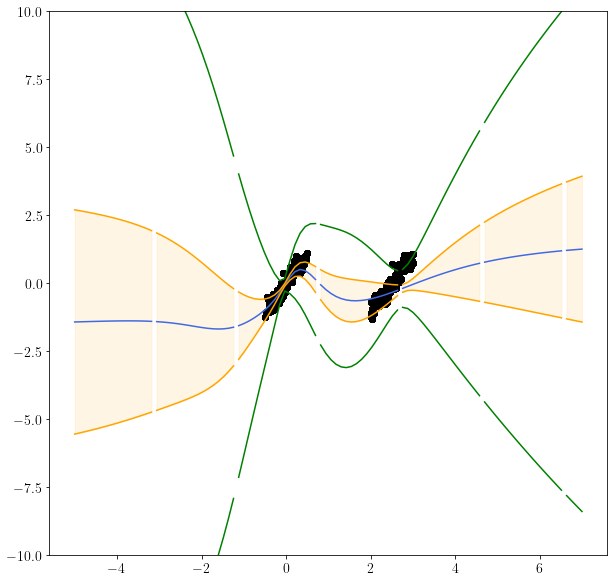

In [12]:
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
fig, ax1 = plt.subplots(1, figsize=(10, 10))
with torch.no_grad():
    for data, target in test_set:
        features = feature_extractor(data)
        y_mean = model(data).squeeze()
        y_cov = features @ my_cov_approx.squeeze().diag() @ torch.transpose(features, 0, 1)
        y_std = y_cov.diagonal().sqrt().squeeze()
        y_cov_backpack = features @ cov.squeeze().diag() @ torch.transpose(features, 0, 1)
        y_std_backpack = y_cov_backpack.diagonal().sqrt().squeeze()
        ax1.plot(data, y_mean, color="royalblue", label="ML prediction/Mean") # mean
        ax1.scatter(x_train, y_train, color="black")
        # std
        ax1.plot(data, y_mean+1.96*y_std, color="orange", label="$+-1.96 \cdot \sigma$")
        ax1.plot(data, y_mean-1.96*y_std, color="orange")
        ax1.plot(data, y_mean+1.96*y_std_backpack, color="green", label="$+-1.96 \cdot \sigma$")
        ax1.plot(data, y_mean-1.96*y_std_backpack, color="green")
        ax1.fill_between(torch.squeeze(data),y_mean+1.96*y_std,y_mean-1.96*y_std, alpha=0.1, color="orange")
        ax1.set_ylim(-10, 10)